In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [24]:
filename = ('/content/drive/MyDrive/CodingDojo/CodingDojo_Part1/Week 2/sales_predictions.csv')
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [26]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [27]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [28]:
#Starting with the column 'Outlet_Size' I've decided to replace the values with the mode.
# Source: https://www.analyticsvidhya.com/blog/2016/02/bigmart-sales-solution-top-20/
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print(outlet_size_mode)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium


In [29]:
#Using a boolean variable specifying missing Item_Weight values.
outlet_size_bool = df['Outlet_Size'].isnull() 
#Imputing data and checking missing values before and after imputation to confirm.
df.loc[outlet_size_bool,'Outlet_Size'] = df.loc[outlet_size_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print(sum(df['Outlet_Size'].isnull()))

0


In [30]:
#Filling in Missing Values in 'Item_Weight' Column with the mean.
#Source: https://discuss.analyticsvidhya.com/t/keyerror-in-big-mart-sales-problem/64919/5
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df['Item_Weight'].head(20)

0      9.300000
1      5.920000
2     17.500000
3     19.200000
4      8.930000
5     10.395000
6     13.650000
7     12.857645
8     16.200000
9     19.200000
10    11.800000
11    18.500000
12    15.100000
13    17.600000
14    16.350000
15     9.000000
16    11.800000
17     9.000000
18    12.857645
19    13.350000
Name: Item_Weight, dtype: float64

In [31]:
#Replacing 0's with mean of the column since '0' doesn't make sense for visibility.
#Source: https://www.analyticsvidhya.com/blog/2016/02/bigmart-sales-solution-top-20/
visibility_avg = df.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (df['Item_Visibility'] == 0)
df.loc[miss_bool,'Item_Visibility'] = df.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print(sum(df['Item_Visibility'] == 0))

0


In [32]:
#Initially when running the code to make bar charts, I noticed there were a few different variations of
#the way the fat contents were spelled. I replaced them to match accordingly.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['low fat', 'LF', 'reg'],['Low Fat', 'Low Fat', 'Regular'])

In [33]:
#There are 3 different types of items that we can break down. Based on the item identifier column, 
#it looks like we have FD as food DR as Drink and NC as non consumable.
#I've decided to make a new column using the item identifier column.
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda x: x[0:2])
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
df['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

In [34]:
#create values for establishment year. After looking at the link where the data set came from, 
#it looks like this data set was posted in 2016 so that will
#be the year that we will be subtracting by to create the values of this new column.
df['Outlet_Years'] = 2016 - df['Outlet_Establishment_Year']
df['Outlet_Years']

0       17
1        7
2       17
3       18
4       29
        ..
8518    29
8519    14
8520    12
8521     7
8522    19
Name: Outlet_Years, Length: 8523, dtype: int64

In [35]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,17
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,7
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,17
3,FDX07,19.20,Regular,0.015274,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,18
4,NCD19,8.93,Low Fat,0.008082,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,29


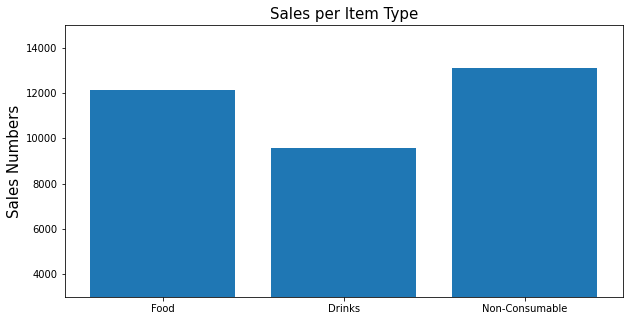

In [36]:
#This is a comparison to find out if sales numbers have any correlation to type 
#of item using our new 'Item type combined' column
#The majorit of items sold are non-consumables such as house hold items

Item_Types = df['Item_Type_Combined'].values
Item_Outlet_Sales = df['Item_Outlet_Sales'].values

fig, axes = plt.subplots(nrows= 1, ncols= 1, figsize = (10, 5))
axes.bar(Item_Types,Item_Outlet_Sales)
axes.set_xlabel('', fontsize = 15)
axes.set_ylabel('Sales Numbers', fontsize = 15)
plt.ylim(3000, 15000) 
axes.set_title('Sales per Item Type', fontsize = 15);


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


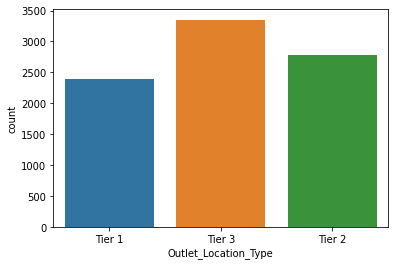

In [37]:
#This bar graph shows supermarket type counts in the data set. 
#The majority are type 3.
sns.countplot(df['Outlet_Location_Type']);

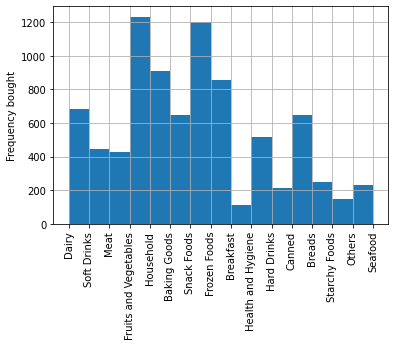

In [38]:
#Part 4 
#Histogram to view the distributions of product sales. 
#The two most frequently sold items are fruits/veggies, and snack foods

df['Item_Type'].hist(xrot=90, bins=15)
plt.ylabel('Frequency bought');

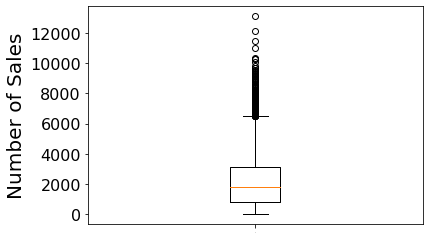

In [39]:
#This boxplot shows at what level most of the products are sold.
#Majority of the product sales are 1000-3000 units
plt.boxplot(df.Item_Outlet_Sales),
plt.ylabel('Number of Sales', fontsize = 20);
plt.xticks(fontsize = 0);
plt.yticks(fontsize = 16);

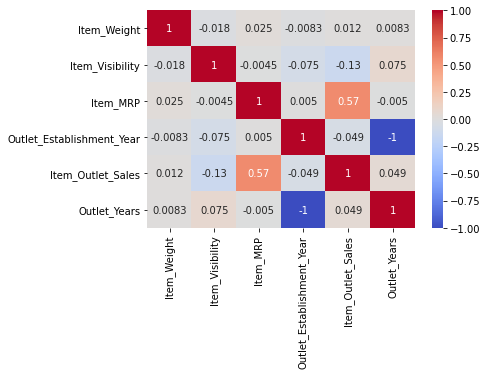

In [40]:
#After creating a heat map, you can see that Item MRP has the highest correlation to Item outlet sales.
#This tells us that the product cost is the number one contributing factor to item sales
#The next closest determining factor would be item visbility.
corr = df.corr()
sns.heatmap(corr, annot=True, cmap= 'coolwarm');

UFuncTypeError: ignored

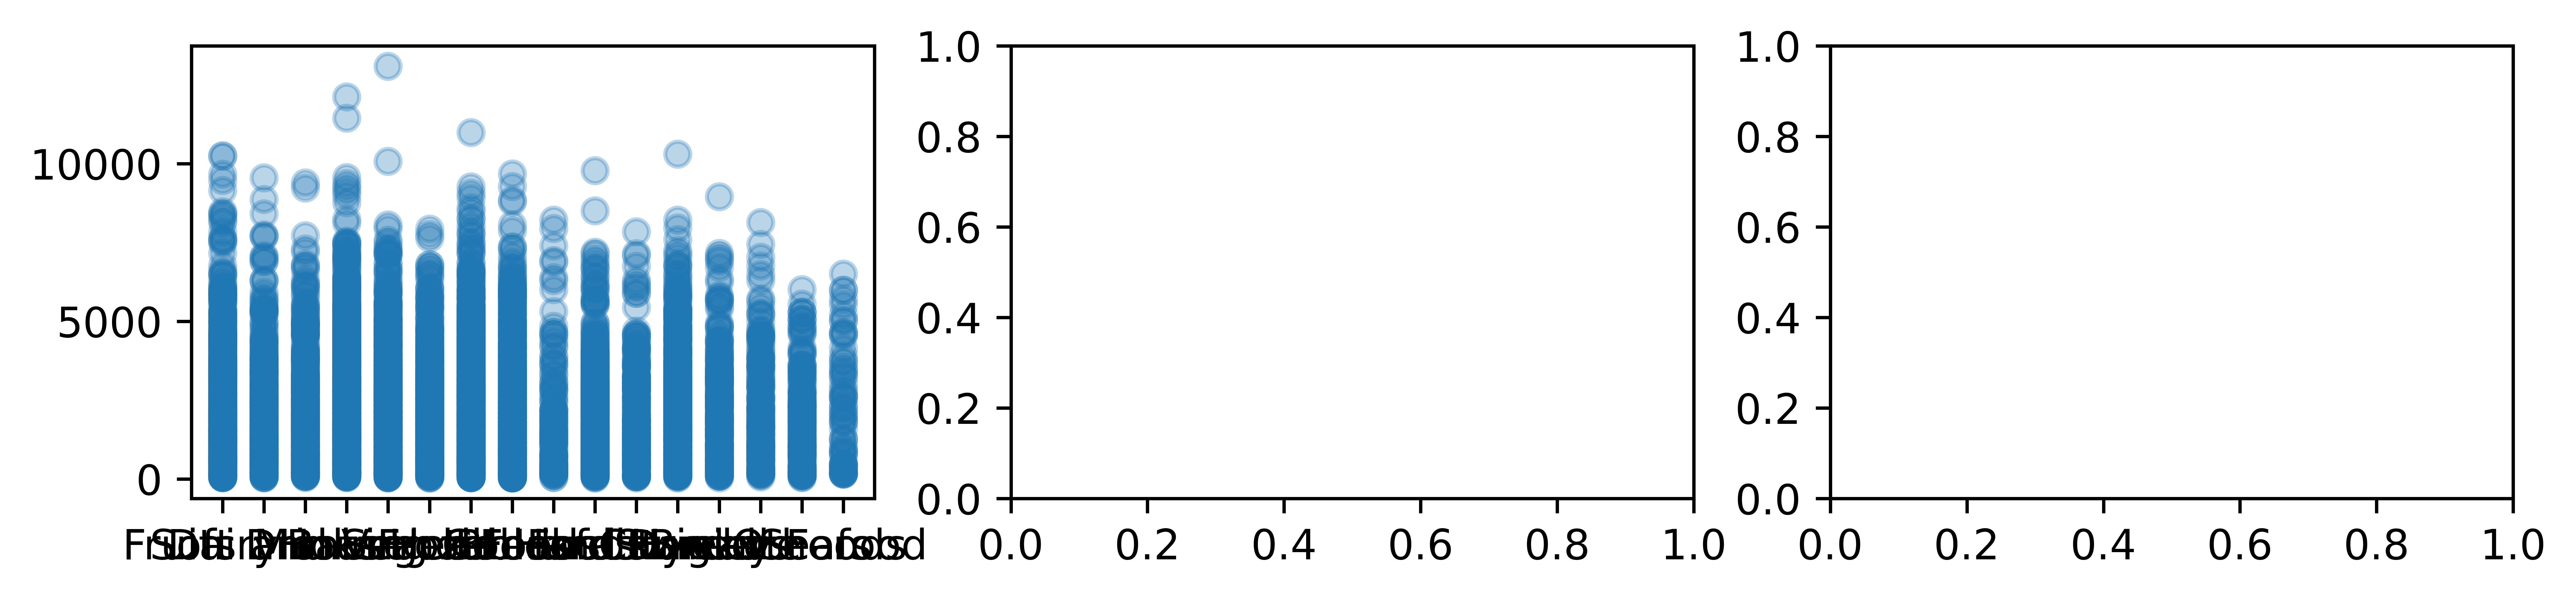

In [41]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=1000)
sns.regplot(x='Item_Type', y='Item_Outlet_Sales', data=df, ci=None, ax = axes[0], scatter_kws={'alpha':0.3});
sns.regplot(x='Item_MRP', y='Item_Outlet_Sales', data=df, ci=None, ax = axes[1], scatter_kws={'alpha':0.3});
sns.regplot(x='Item_Visibility', y='Item_Outlet_Sales', data=df, ci=None, ax = axes[2], scatter_kws={'alpha':0.3});
fig.tight_layout()

In [ ]:
#Part 5
#Use the data you have cleaned in previous weeks. 
#This should not have any missing data and you should deal with categorical variables appropriately.
#The "Item_Outlet_Sales" column is your target. Build a model to predict this.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Item_Type_Combined         8523 non-null   object 
 13  Outlet_Years               8523 non-null   int64

In [43]:
#Making new column for Outlet_Identifier to make it a variable
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])

#Transforming data from categorical to numerical.

var_mod = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [44]:
#Using get dummies to one hot encode columns into new columns
df = pd.get_dummies(df, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])
df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Type_Combined_0,Item_Type_Combined_1,Item_Type_Combined_2,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.30,0.016047,4,249.8092,OUT049,1999,3735.1380,17,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,0.019278,14,48.2692,OUT018,2009,443.4228,7,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0.016760,10,141.6180,OUT049,1999,2097.2700,17,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,0.015274,6,182.0950,OUT010,1998,732.3800,18,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.008082,9,53.8614,OUT013,1987,994.7052,29,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [45]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                      int64
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
Outlet_1                       uint8
Outlet_2                       uint8
O

In [46]:
#Target = df['Item_Outlet_Sales']
X = df.loc[:,['Item_Weight', 'Item_Visibility', 'Item_Type','Item_MRP',
       'Item_Fat_Content_0', 'Item_Fat_Content_1',
       'Outlet_Location_Type_0', 'Outlet_Location_Type_1',
       'Outlet_Location_Type_2', 'Outlet_Size_0', 'Outlet_Size_1',
       'Outlet_Size_2', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_2',
       'Outlet_Type_3', 'Item_Type_Combined_0', 'Item_Type_Combined_1',
       'Item_Type_Combined_2', 'Outlet_0', 'Outlet_1', 'Outlet_2', 'Outlet_3',
       'Outlet_4', 'Outlet_5', 'Outlet_6', 'Outlet_7', 'Outlet_8', 'Outlet_9']]
X.shape

(8523, 29)

In [47]:
y = df.loc[:, 'Item_Outlet_Sales'].values
y.shape

(8523,)

In [48]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
preds = lr.predict(X)

In [50]:
lr.score(X, y)

0.563470749631876

In [51]:
#Linear Regression with Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [52]:
lr_tts = LinearRegression()
lr_tts.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
#Training R2 score
lr_tts.score(X_train, y_train)

0.5544446345206259

In [54]:
#Testing R2 score
lr_tts.score(X_test, y_test)

0.5899770878562216

In [55]:
#KNN without train-test-split
#standardize data, fit/transform X
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [56]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_scaled, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [57]:
#KNN w/o train-test-split R2 score
knn_reg.score(X_scaled, y)

0.6706838890818545

In [58]:
#KNN with train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [60]:
# Standardize data, fit/transform X (Always fit on the training data)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
knn_tts = KNeighborsRegressor()
knn_tts.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [62]:
#KNN training R2 score
knn_tts.score(X_train, y_train)

0.6643653701896703

In [63]:
#KNN testing R2 score
knn_tts.score(X_test, y_test)

0.5150980515117751

In [64]:
#Bagged Trees
bt = BaggingRegressor()
bt.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [65]:
#bagged tree training score
bt.score(X_train, y_train)

0.9142520976163613

In [66]:
#bagged tree testing score
bt.score(X_test, y_test)

0.540357191419919

In [67]:
#Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [68]:
#random forest train r2 score
rf.score(X_train, y_train)

0.9376850682510964

In [69]:
#random forest test r2 score
rf.score(X_test, y_test)

0.5728778176178762

In [71]:
rf.feature_importances_

array([5.59644516e-02, 1.11473298e-01, 4.20954199e-02, 4.37179539e-01,
       5.73033414e-03, 5.14768508e-03, 4.04923362e-03, 4.17586151e-03,
       3.17500024e-03, 2.52454297e-03, 3.05736488e-03, 3.56519607e-03,
       1.97934573e-01, 2.66108626e-03, 1.66854774e-03, 3.80037642e-02,
       3.51852304e-03, 4.54316734e-03, 4.26032676e-03, 1.99650218e-05,
       2.69131637e-03, 6.53988057e-03, 1.93896007e-03, 1.43161932e-05,
       3.55467293e-02, 6.97727647e-03, 6.60247465e-03, 5.43475186e-03,
       3.50641330e-03])

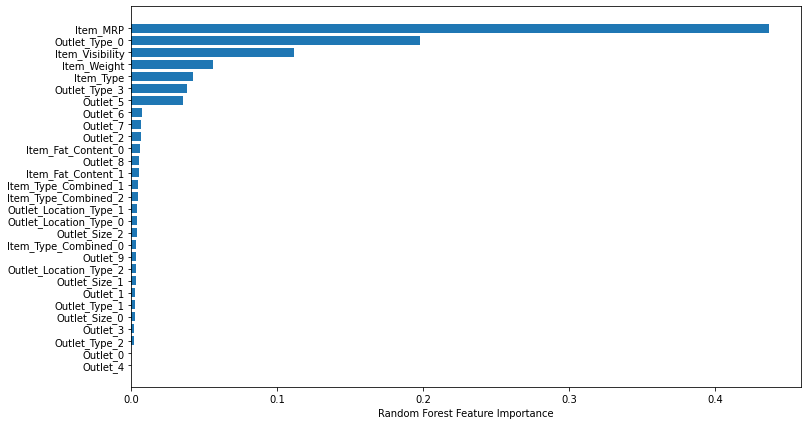

In [75]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize = (12, 7))
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");